<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/accelerating_metagenomic_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accelerating metagenomic analysis with [Graphistry](graphistry.com), Part II, focusing on viral tracing over time

## [viral calling pipeline here](https://github.com/dcolinmorgan/viral_snake)

Using GPU-accelerated UMAP + DBScan analysis & visualization, metagenomic samples can be compared faster and much more easily explored.

*   Task: Analyze metagenomic samples for similarity
*   Data: time series samples
**   563 samples collected from 84 donors, producing 4 dense long-term time series (up to 1 sample every other day during 18 months)
*   [data](https://www.ebi.ac.uk/ena/browser/view/PRJNA544527)
*   [metadata](https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-019-0559-3/MediaObjects/41591_2019_559_MOESM3_ESM.xlsx)
*   [paper](https://sci-hub.se/10.1038/s41591-019-0559-3)


**Insight/ Result:**

43s to umap and dbscan vs 2342s here
over **50X** faster for a single run, and since [the reference paper for this analysis](https://journals.asm.org/doi/full/10.1128/msystems.00118-23) runs this analysis 12x per dataset (here we only have 1 dataset), we could expect to save nearly the entire 8hrs for this dataset, taking less than 10 minutes in total

(See also: [CPU baseline](https://github.com/dcolinmorgan/grph/blob/main/generic_metagenomic_demo.ipynb))

# Setup

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11 cudf-cu11 cugraph-cu11 pylibraft_cu11 raft_dask_cu11 dask_cudf_cu11 pylibcugraph_cu11 pylibraft_cu11
import cuml,cudf
print(cuml.__version__)

!pip install -U --force git+https://github.com/graphistry/pygraphistry.git@feat/gpu-featurization
!pip install -U git+https://github.com/graphistry/cu-cat.git@DT4
# !pip install dirty_cat

!pip install Biopython

!nvidia-smi


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# import /configure

get a free api-key at https://www.graphistry.com/


In [ ]:
import pandas as pd
import graphistry
from time import time
import cuml,cudf
print(cuml.__version__)


graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
graphistry.__version__

23.06.00


'0.29.1+5.g777afd4'

# bio-ml dataset


1.   [3 subjects x 10 time points](
https://www.ebi.ac.uk/ena/browser/view/PRJNA544527)

2.  [metadata](
https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-019-0559-3/MediaObjects/41591_2019_559_MOESM3_ESM.xlsx)

3.   !wget https://raw.githubusercontent.com/dcolinmorgan/grph/main/ftp_PRJNA544527.txt


In [ ]:
# !wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR922/006/SRR9224006/SRR9224006_1.fastq.gz
# !wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR922/006/SRR9224006/SRR9224006_2.fastq.gz

In [ ]:
# ! gunzip SRR9224006_1.fastq.gz
# ! gunzip SRR9224006_2.fastq.gz

In [ ]:
# !head /content/SRR9224006_1.fastq

In [ ]:
# from Bio import SeqIO
# import glob,os
# import pandas as pd
# B=pd.DataFrame()
# for i in glob.glob('/content/*.fastq'):
#     # j=os.path.basename(i)
#     fasta_sequences = SeqIO.parse(open(i),'fastq')
#     identifiers = []
#     sequences = []
#     for fasta in fasta_sequences:
#         name, sequence = fasta.id, str(fasta.seq)
#         identifiers.append(name)
#         sequences.append(sequence)

#     A=pd.DataFrame([identifiers,sequences]).T
#     A.columns=['ID','seq']
#     A.dropna(inplace=True)
#     B=B.append(A)
#     # A['ID']#=A.ID.str.split('-')[0:1]
# # B['ID']=B['ID'].str.split('-').str[0]+'_'+B['ID'].str.split('-').str[1]#.cat()
# B['ID']=B.ID.str.split('_length').str[0]
# B.index=B.ID

# install [HUMAnN 3](https://huttenhower.sph.harvard.edu/humann), a method for efficiently and accurately profiling the abundance of microbial metabolic pathways and other molecular functions from metagenomic or metatranscriptomic sequencing data.

In [ ]:
# !pip install humann --no-binary :all:
# !pip install metaphlan

In [ ]:
### !humann_databases --download utility_mapping full /path/to/databases --update-config yes

# !humann_test

# !wget https://github.com/biobakery/humann/raw/master/examples/demo.fastq.gz
# !humann -i demo.fastq.gz -o sample_results

### takes very long for running all samples
 (1day+ run on cluster)

In [ ]:
# mkdir assemble epi_sam_out mpa4_out
# # !humann -i /content/All_MAGs/Sample_101_S75_bin_1.fa -o test_out
# %%bash
# seq=$(ls /content/*.fastq | cut -d / -f2| cut -d _ -f1)

# for i in $(eval "echo "$seq" | cut -d _ -f1")

# do
# metaphlan /content/${i}.fa --nproc 40 --input_type fasta -o /content/assemble/${i}/h4_out.txt -t rel_ab_w_read_stats
# done

# umap and dbscan

idea for metagenomic analysis based on [Quantifying Shared and Unique Gene Content across 17 Microbial Ecosystems
](https://journals.asm.org/doi/full/10.1128/msystems.00118-23)

(analyze all samples run on cluster)

also this [paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0997-x?ref=https://codemonkey.link#Sec7) and [method](https://github.com/marbl/Mash/blob/master/INSTALL.txt)



In [ ]:
# from sqlalchemy.util.compat import dataclass_fields
!wget https://github.com/dcolinmorgan/grph/raw/main/PRJNA544527_mpa4out.txt
data=pd.read_csv('/content/PRJNA544527_mpa4out.txt',sep='\t',skiprows=1,index_col=0)
data.index=data.reset_index().clade_name.str.split('|',expand=True)[6]
data=data.reset_index().dropna(axis=0)
data.index=data[6]
data=data.drop(columns=6)

!wget https://raw.githubusercontent.com/dcolinmorgan/grph/main/PRJNA544527-meta_inf.txt
meta=pd.read_csv('/content/PRJNA544527-meta_inf.txt',sep='\t',header=None)

mm=pd.merge(data.T,meta[[3,5]],left_index=True,right_on=3)

mm['id']=mm[5].str.split('-').str[0]
mm['time']=mm[5].str.split('_').str[0].str.split('-').str[1]

!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-019-0559-3/MediaObjects/41591_2019_559_MOESM3_ESM.xlsx
metaa=pd.read_excel('/content/41591_2019_559_MOESM3_ESM.xlsx',sheet_name='SupTable2',skiprows=3)
metaa=metaa[['Donor','Age','Sex','BMI']]

Full_table=pd.merge(mm,metaa,left_on='id',right_on='Donor')
Full_table=Full_table.drop(columns=[3,	5,	'id'])
# Full_table.time=pd.to_datetime(Full_table.time,unit='d')
# Full_table.time=Full_table.time.values.astype('datetime64[M]')

data2=Full_table.melt(id_vars=['time','Donor','Age','Sex','BMI'])
# data2.to_csv('PRJNA544527_mpa4_annot_table.txt',sep='\t')

data2=data2.rename(columns={'variable':'species'})
data2=data2.sort_values(by=['Donor','time','value'])
# final df stored here also
# !wget https://raw.githubusercontent.com/dcolinmorgan/grph/main/PRJNA544527_mpa4_annot_table.txt
# data2=pd.read_csv('PRJNA544527_mpa4_annot_table.txt',sep='\t',index_col=0)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/PRJNA544527_mpa4_annot_table.txt /content/drive/MyDrive/graphistry/metagen_demo/

In [ ]:
(data2.species)+'_'+(data2.Donor)

2678            s__Bacteroides_clarus_aa
5378      s__Bacteroides_intestinalis_aa
9158           s__Ruminococcus_bromii_aa
12938              s__GGB6601_SGB9333_aa
13478              s__GGB3256_SGB4303_aa
                       ...              
613383            s__GGB51647_SGB4348_dl
287223       s__Phocaeicola_coprocola_dl
300183       s__Phocaeicola_coprocola_dl
178143        s__Phocaeicola_plebeius_dl
219183        s__Phocaeicola_plebeius_dl
Length: 1310040, dtype: object

In [ ]:
# data2.index=data2.species+'_'+data2.Donor
data2[data2['value']>1]

,time,Donor,Age,Sex,BMI,species,value
39938,0154,aa,29,Male,24.1,s__Desulfovibrio_piger,1.00422
958478,0154,aa,29,Male,24.1,s__Desulfovibrio_piger,1.00422
11318,0154,aa,29,Male,24.1,s__Odoribacter_splanchnicus,1.12785
77198,0154,aa,29,Male,24.1,s__Odoribacter_splanchnicus,1.12785
73418,0154,aa,29,Male,24.1,s__Faecalibacterium_prausnitzii,1.14483
...,...,...,...,...,...,...,...
613383,0006,dl,32,Male,26.1,s__GGB51647_SGB4348,5.42813
287223,0006,dl,32,Male,26.1,s__Phocaeicola_coprocola,24.16670
300183,0006,dl,32,Male,26.1,s__Phocaeicola_coprocola,24.16670
178143,0006,dl,32,Male,26.1,s__Phocaeicola_plebeius,28.49330


In [ ]:
data

,SRR9224004,SRR9224005,SRR9224006,SRR9224007,SRR9224008,SRR9224009,SRR9224010,SRR9224011,SRR9224012,SRR9224013,...,SRR9224554,SRR9224555,SRR9224556,SRR9224557,SRR9224558,SRR9224560,SRR9224562,SRR9224563,SRR9224564,SRR9224566
6,,,,,,,,,,,,,,,,,,,,,
s__Eubacterium_rectale,9.66295,9.81136,14.82533,2.20691,1.21966,12.31280,17.09289,2.44399,0.32817,1.38337,...,0.17943,0.23359,2.89280,2.23934,0.00000,16.99579,12.38639,10.36104,11.34234,14.66425
s__Bacteroides_uniformis,8.78315,8.85121,7.13981,18.60528,12.67926,13.92111,5.49703,28.62590,20.36611,9.53160,...,8.03565,11.50562,12.07718,20.28629,8.80642,4.65190,10.48361,10.76942,13.86282,11.01886
s__Phocaeicola_vulgatus,7.87163,1.84120,27.58737,17.43556,23.91699,23.66567,36.20894,12.50293,18.27994,1.96795,...,4.43756,3.70480,5.93137,3.94097,9.08411,21.78286,23.46065,20.67648,18.94887,14.10248
s__Phocaeicola_massiliensis,6.83574,1.71725,9.28006,0.01754,0.00608,0.00000,0.00000,0.00000,0.00000,0.00000,...,9.41414,2.44829,0.72865,0.64923,8.89782,5.34949,6.79459,7.27276,7.26365,7.28567
s__Bacteroides_clarus,6.50124,7.00490,2.93553,0.00021,0.00267,0.00000,0.00000,0.00000,0.00066,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.33849,2.35695,2.23865,2.16099,3.47488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s__Bacteroides_mediterraneensis,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,13.77536,15.74308,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
s__GGB3343_SGB4423,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,2.03774,1.21952,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
s__GGB3139_SGB4152,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.17281,0.02003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## UMAP by species


In [ ]:
data=pd.read_csv('/content/PRJNA544527_mpa4out.txt',sep='\t',skiprows=1,index_col=0)

g = graphistry.nodes(cudf.from_pandas(data))

t=time()
g2=g.featurize(feature_engine='cu_cat',memoize=False)
g3=g2.umap(dbscan=True,engine='cuml')
print("\n"+str(time()-t))

emb2=g3._node_embedding
# emb2['time']=data2.time
# emb2['_n']=data2.species
# emb2['index']=data2.species
g22=graphistry.nodes(emb2.reset_index(),'index').edges(g3._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
##440s


16.825986862182617


In [ ]:
data.index

In [ ]:
A=emb2.reset_index()['clade_name'].to_pandas().str.split('|').str[6]#.str.split('|').str[0]#+'_'+data2.Donor
emb2.index=A

In [ ]:
B=g3._edges
B['_src_implicit'] = B['_src_implicit'].replace(A, regex=True)#apply(lambda x: [A[i] for i in x])
B['_dst_implicit'] = B['_dst_implicit'].replace(A, regex=True)

## add this regex replacement rather than merge

In [ ]:
# g3._edges[g3._edges['_src_implicit']!=g3._edges['_dst_implicit']]
g22=graphistry.nodes(emb2.reset_index(),'clade_name').edges(g3._edges.dropna(),'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})

g22.plot()

## UMAP for patient by time stamp

In [ ]:
data2=data2[data2.value>0]
data2=data2.reset_index(drop = True)
data2=data2.drop_duplicates()

data2["Label"] = (
    data2.groupby("Donor")
    .apply(lambda x: x.groupby("time", sort=False).ngroup() + 1)
    .values
)

cc=pd.unique(data2[data2.Label<5].Donor)
data2=data2.loc[ data2.Donor.isin(cc), : ]
data2=data2[data2.Label<5]

data2["rank"] = data2.groupby("Donor")["value"].rank(method="dense", ascending=False)
data2=data2[data2['rank']<10.0]


In [ ]:
data2['id_time']=data2['Donor']+'_'+data2['Label'].apply(str)

In [ ]:
data3=data2[['id_time','species','value']]

In [ ]:
df2 = data3.pivot_table(index=['id_time'],columns='species')
df3=df2.fillna(0).reset_index()
df4=df3.droplevel(0, axis=1)
df4.index=df4.iloc[:,0]
df4=df4.loc[:, df4.columns.str.startswith('s__')]

g = graphistry.nodes(cudf.from_pandas(df4))

t=time()
g2=g.featurize(feature_engine='cu_cat',memoize=False)
g3=g2.umap(dbscan=True,engine='cuml')
print("\n"+str(time()-t))

emb2=g3._node_embedding
# emb2['time']=data2.time
# emb2['_n']=data2.species
# emb2['index']=data2.species
# g22=graphistry.nodes(emb2.reset_index(),'id_time').edges(g3._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})


A=emb2.reset_index().iloc[:,0].to_pandas() #emb2.reset_index()['id_time'].to_pandas()#.str.split('|').str[6]#.str.split('|').str[0]#+'_'+data2.Donor
emb2.index=A

B=g3._edges
B['_src_implicit'] = B['_src_implicit'].replace(A, regex=True)#apply(lambda x: [A[i] for i in x])
B['_dst_implicit'] = B['_dst_implicit'].replace(A, regex=True)

emb2['id_time']=emb2.index
g22=graphistry.nodes(emb2.reset_index(),'id_time').edges(g3._edges.dropna(),'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})

g22.plot()


0.2730567455291748


[per the Materials and Methods of our inspirational paper,](https://journals.asm.org/doi/full/10.1128/msystems.00118-23#sec-4)from these (too) many clusters, one can perform cluster-based functional enrichment analysis, cluster-based taxonomoical enrichment analysis and/or identify of ecologically conserved genes and differentially abundant genes

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
data2['genus']=data2['species'].str.split('_').str[2]

chars = '0123456789ABCDEF'
palette_colors=['#'+''.join(random.sample(chars,6)) for i in range(len(pd.unique(data2.genus)))]
palette_dict = {genus: color for genus, color in zip(pd.unique(data2.genus), palette_colors)}


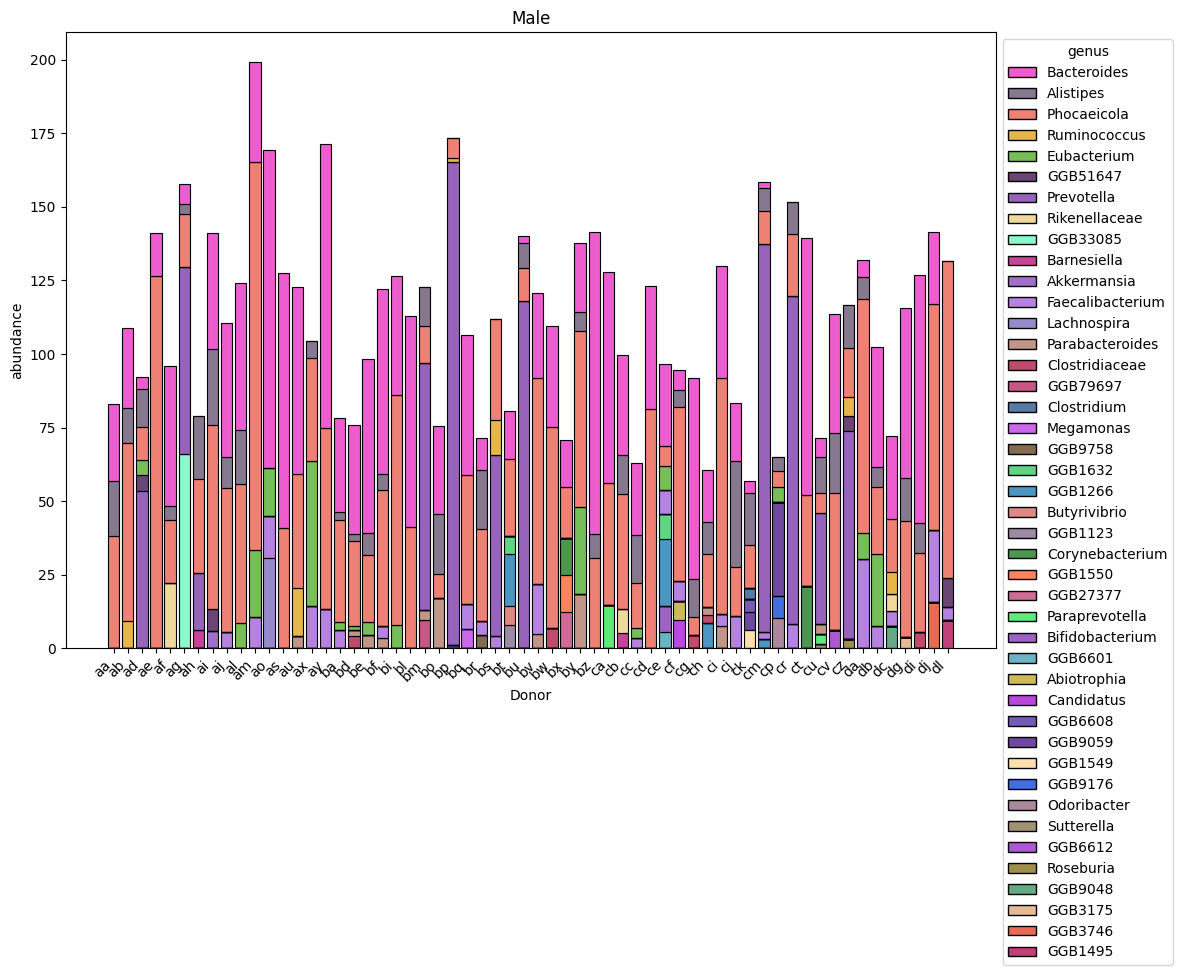

In [ ]:

plt.figure(figsize=(12,8))
ax = sns.histplot(data2[data2['Sex']=='Male'], x='Donor', hue='genus', weights='value',
             multiple='stack', palette=palette_dict, shrink=0.8)
ax.set_ylabel('abundance')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Male')

legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))


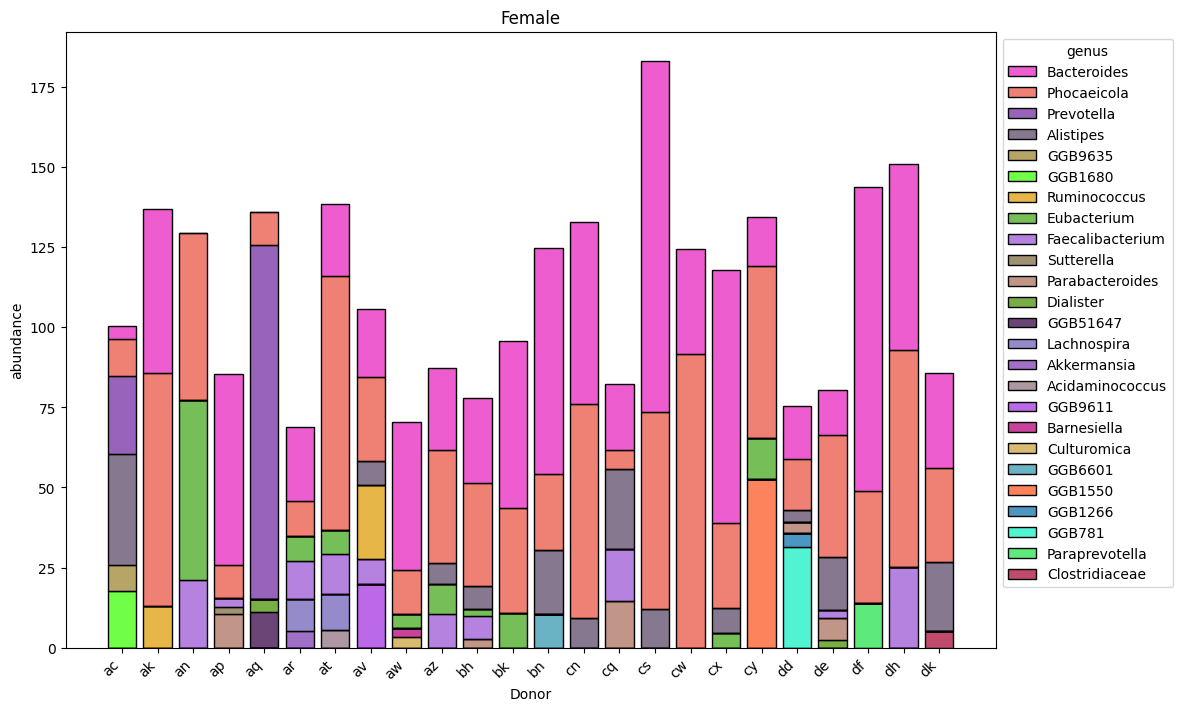

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data2[data2['Sex']=='Female'], x='Donor', hue='genus', weights='value',
             multiple='stack', palette=palette_dict, shrink=0.8)
ax.set_ylabel('abundance')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Female')

legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))


In [ ]:
data2=data2[data2.value>0]
data2=data2.reset_index(drop = True)
data2=data2.drop_duplicates()

data2["Label"] = (
    data2.groupby("Donor")
    .apply(lambda x: x.groupby("time", sort=False).ngroup() + 1)
    .values
)

cc=pd.unique(data2[data2.Label<5].Donor)
data2=data2.loc[ data2.Donor.isin(cc), : ]
data2=data2[data2.Label<5]

data2["rank"] = data2.groupby("Donor")["value"].rank(method="dense", ascending=False)
data2=data2[data2['rank']<10.0]


grouped = data2.groupby('Donor')
def get_next_clus(x): return x['species'].shift(-1)
data2["next_species"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)
grouped = data2.groupby('Donor')

  # Working on the «nodes_dict
import random
data2_spec = list(data2.species.unique())
chars = '0123456789ABCDEF'
palette=[''+''.join(random.sample(chars,6)) for i in range(len(data2_spec))]
output = dict()
output.update({'nodes_dict': dict()})
i = 0
for Label in data2.Label.unique():
    output['nodes_dict'].update(
        {Label: dict()}
    )

    data2_spec_at_this_Label = data2[data2['Label'] ==
                                   Label]['species'].unique()

    Label_palette = []
    for spec in data2_spec_at_this_Label:
        Label_palette.append(palette[list(data2_spec).index(spec)])

    output['nodes_dict'][Label].update(
        {
            'sources': list(data2_spec_at_this_Label),
            'color': Label_palette,
            'sources_index': list(range(i, i+len(data2_spec_at_this_Label)))
        }
    )
    i += len(output['nodes_dict'][Label]['sources_index'])


  # Working on the links_dict
import random
output.update({'links_dict': dict()})
grouped = data2.groupby(['Donor', 'Label'])

def update_source_target(user):
    try:

        source_index = output['nodes_dict'][user.name[1]]['sources_index'][output['nodes_dict']
                                                                           [user.name[1]]['sources'].index(user['species'].values[0])]

        target_index = output['nodes_dict'][user.name[1] + 1]['sources_index'][output['nodes_dict']
                                                                               [user.name[1] + 1]['sources'].index(user['next_species'].values[0])]

         # If this source is already in links_dict...
        if source_index in output['links_dict']:
            # ...and if this target is already associated to this source...
            if target_index in output['links_dict'][source_index]:
                # ...then we increment the count of users with this source/target pair by 1
                output['links_dict'][source_index][target_index]['value'] += 1
            # ...but if the target is not already associated to this source...
            else:
                # ...we create a new key for this target, for this source, and initiate it with 1 user and the time from source to target
                output['links_dict'][source_index].update({target_index:
                                                           dict(
                                                               {'value': 1}
                                                            )
                                                           })
        # ...but if this source isn't already available in the links_dict, we create its key and the key of this source's target, and we initiate it with 1 user and the time from source to target
        else:
            output['links_dict'].update({source_index: dict({target_index: dict(
                {'value': 1})})})
    except Exception as e:
        pass

grouped.apply(lambda user: update_source_target(user))

""


In [ ]:
targets = []
sources = []
values = []

for source_key, source_value in output['links_dict'].items():
    for target_key, target_value in output['links_dict'][source_key].items():
        sources.append(source_key)
        targets.append(target_key)
        values.append(target_value['value'])

labels = []
colors = []

for key, value in output['nodes_dict'].items():
    labels = labels + list(output['nodes_dict'][key]['sources'])
    colors = colors + list(output['nodes_dict'][key]['color'])
for idx, color in enumerate(colors):
    colors[idx] = "#" + str(color) + ""

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import seaborn as se
import matplotlib.pyplot as plt
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=20,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        hovertemplate='%{value} unique species episodes went from %{source.label} to %{target.label}.',
    ))])

fig.update_layout(autosize=True, title=dict(text="Movement of Top 10 Species During Time Series", font_size=16), font=dict(size=12, family="Arial"), plot_bgcolor='white')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)

In [ ]:
!pip install chart_studio
import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='dcolinmorgan', api_key='***')
py.iplot(fig, sharing='public', filename='Meta-time-sankey')